# Attempting a minimal diffusion model

In [ ]:
import logging, torch, torchvision, torch.nn.functional as F, torchvision.transforms.functional as TF, matplotlib as mpl
from matplotlib import pyplot as plt
from functools import partial
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torchvision.utils import make_grid
from datasets import load_dataset,load_dataset_builder
from miniai.datasets import *
from miniai.learner import *
from fastprogress import progress_bar

In [ ]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

Load a dataset:

In [ ]:
x,y = 'image','label'
name = "mnist" #"fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([256, 1, 28, 28]), tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4]))

Define a model:

In [ ]:
def conv2d(inc, outc): return nn.Conv2d(inc, outc, kernel_size=5, padding=2)

In [ ]:
class BasicUNet(nn.Module):
    "A minimal UNet implementation."
    def __init__(self, inc, outc):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([conv2d(inc, 32), conv2d(32, 64), conv2d(64, 64)])
        self.up_layers = torch.nn.ModuleList([conv2d(64, 64), conv2d(64, 32), conv2d(32, outc)])

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = F.silu(l(x))
            h.append(x)
            if i < 2: x = F.max_pool2d(x, 2)
        for i, l in enumerate(self.up_layers):
            if i > 0: x = F.interpolate(x, scale_factor=2)
            x += h.pop()
            x = l(x)
            if i<len(self.up_layers)-1: x = F.silu(x)
        return (x.sigmoid()*2)-0.5

Define the corruption:

In [ ]:
def corrupt(x, amount):
    "Corrupt the input `x` by mixing it with noise according to `amount`"
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return x*(1-amount) + noise*amount

Logging callback:

In [ ]:
class LogLossesCB(Callback):
    def __init__(self): self.losses = []
    def after_batch(self): self.losses.append(self.learn.loss.item())
    def after_fit(self): plt.plot(self.losses)

I chose to write a new training callback:

In [ ]:
class MyTrainCB(TrainCB):
    def predict(self):
        bs = self.learn.batch[0].shape[0]
        noise_amount = torch.rand(bs).to(self.learn.batch[0].device) # Chose random corruption amount
        noisy_images = corrupt(self.learn.batch[0], noise_amount) # Noisy images as net inputs
        self.learn.preds = self.learn.model(noisy_images)
    def get_loss(self):
        self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[0]) # Clean images as targets

In [ ]:
model = BasicUNet(1, 1)
cbs = [MyTrainCB(), CudaCB(), ProgressCB(), LogLossesCB()]
learn = Learner(model, dls, nn.MSELoss(), lr=1e-3, cbs=cbs, opt_func=optim.Adam)

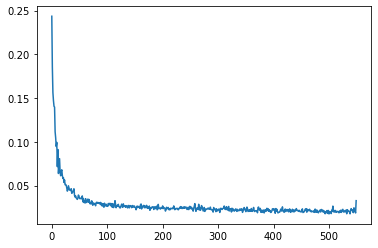

In [ ]:
learn.fit(2) 

Viewing the predictions on images with increasing noise levels:

In [ ]:
# Some noisy data
xb = xb[:8].cpu()
amount = torch.linspace(0, 1, xb.shape[0]) # Left to right -> more corruption
noised_x = corrupt(xb, amount)

In [ ]:
with torch.no_grad(): preds = model(noised_x.cuda()).detach().cpu()

In [ ]:
def show_grid(ax, tens, title=None):
    if title: ax.set_title(title)
    ax.imshow(make_grid(tens.cpu())[0])

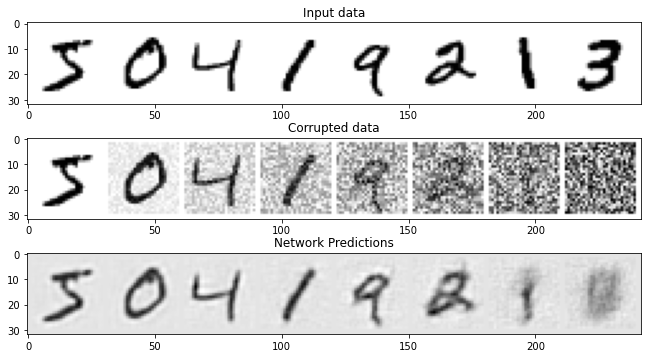

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(11, 6))
show_grid(axs[0], xb, 'Input data')
show_grid(axs[1], noised_x, 'Corrupted data')
show_grid(axs[2], preds, 'Network Predictions')

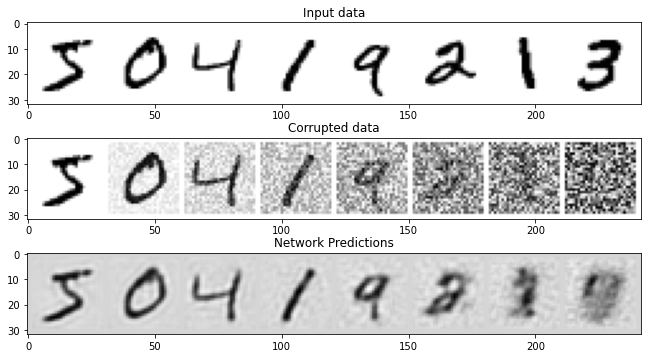

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(11, 6))
show_grid(axs[0], xb, 'Input data')
show_grid(axs[1], noised_x, 'Corrupted data')
show_grid(axs[2], preds, 'Network Predictions')

(array([167., 465.,  17.,  21.,  12.,  14.,  15.,  24.,  25.,  24.]),
 array([-0.15662476, -0.02430023,  0.10802431,  0.24034885,  0.3726734 ,
         0.5049979 ,  0.6373225 ,  0.769647  ,  0.9019715 ,  1.034296  ,
         1.1666206 ], dtype=float32),
 <BarContainer object of 10 artists>)

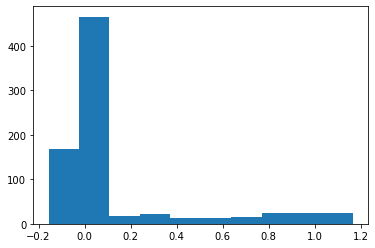

In [ ]:
plt.hist(preds[0].reshape(-1))

A very basic sampling method (not ideal), just taking 5 or 10 equal-sized steps towards the models prediction:

In [ ]:
# Take one: just break the process into 5 or 10 steps and move 1/10'th of the way there each time:
device = 'cuda'
n_steps = 5
xb = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = [xb.detach().cpu()]
pred_output_history = []

In [ ]:
for i in range(n_steps):
    with torch.no_grad(): pred = model(xb) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    xb = xb*(1-mix_factor) + pred*mix_factor # Move part of the way there
    if i < n_steps-1: step_history.append(xb.detach().cpu()) # Store step for plotting

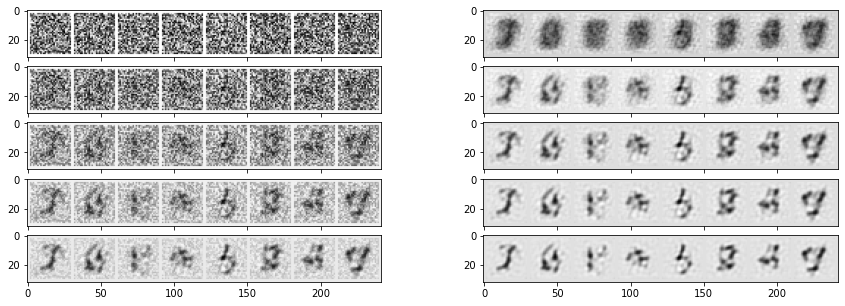

In [ ]:
fig, axs = plt.subplots(n_steps, 2, figsize=(15, n_steps), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(make_grid(step_history[i])[0]),
    axs[i, 1].imshow(make_grid(pred_output_history[i])[0])

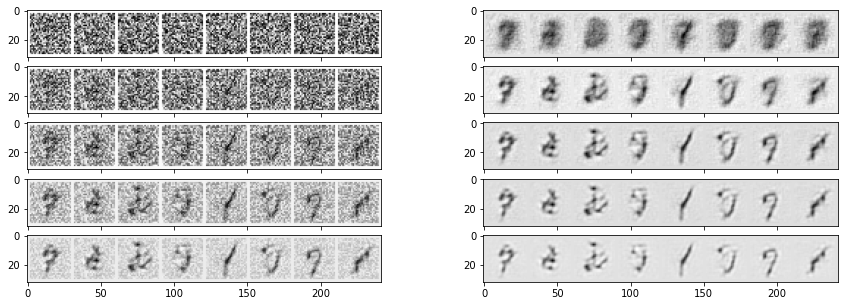

In [ ]:
fig, axs = plt.subplots(n_steps, 2, figsize=(15, n_steps), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(make_grid(step_history[i])[0]),
    axs[i, 1].imshow(make_grid(pred_output_history[i])[0])

# Class Conditioning

Giving the model the labels as conditioning.

In [ ]:
class ClassConditionedUNet(nn.Module):
    "Wraps a BasicUNet but adds several input channels for class conditioning"
    def __init__(self, in_channels, out_channels, num_classes=10, class_emb_channels=4):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_channels)
        self.net = BasicUNet(in_channels+class_emb_channels, out_channels) # input channels = in_channels+1+class_emb_channels

    def forward(self, x, class_labels):
        n,c,w,h = x.shape
        class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
        class_cond = class_cond.view(n, class_cond.shape[1], 1, 1).expand(n, class_cond.shape[1], w, h) # Reshape
        
        # Net input is now x, noise amound and class cond concatenated together
        net_input = torch.cat((x, class_cond), 1)
        return self.net(net_input)

In [ ]:
class MyTrainCB(TrainCB):
    def predict(self):
        bs = self.learn.batch[0].shape[0]
        noise_amount = torch.rand(bs).to(self.learn.batch[0].device)
        noisy_images = corrupt(self.learn.batch[0], noise_amount)
        self.learn.preds = self.learn.model(noisy_images, self.learn.batch[1]) # << Labels as conditioning
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[0])

In [ ]:
model = ClassConditionedUNet(1, 1)
cbs = [MyTrainCB(), CudaCB(), ProgressCB(), LogLossesCB()]
learn = Learner(model, dls, nn.MSELoss(), lr=1e-3, cbs=cbs, opt_func=optim.Adam)

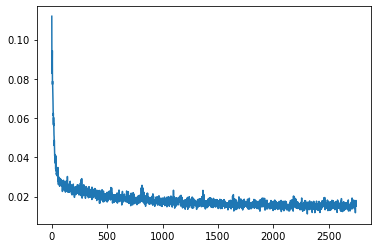

In [ ]:
learn.fit(10)

Sampling as before over 20 steps, but this time with the labels as conditioning:

In [ ]:
n_steps = 20
xb = torch.rand(80, 1, 28, 28).cuda()
yb = torch.tensor([[i]*8 for i in range(10)]).flatten().cuda()

In [ ]:
for i in range(n_steps):
    noise_amount = torch.ones((xb.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad():
        pred = model(xb, yb)
    mix_factor = 1/(n_steps - i)
    xb = xb*(1-mix_factor) + pred*mix_factor
    
    # Optional: Add a bit of extra noise back at early steps
    if i < 10: xb = corrupt(xb, torch.ones((xb.shape[0], )).to(device)*0.05)

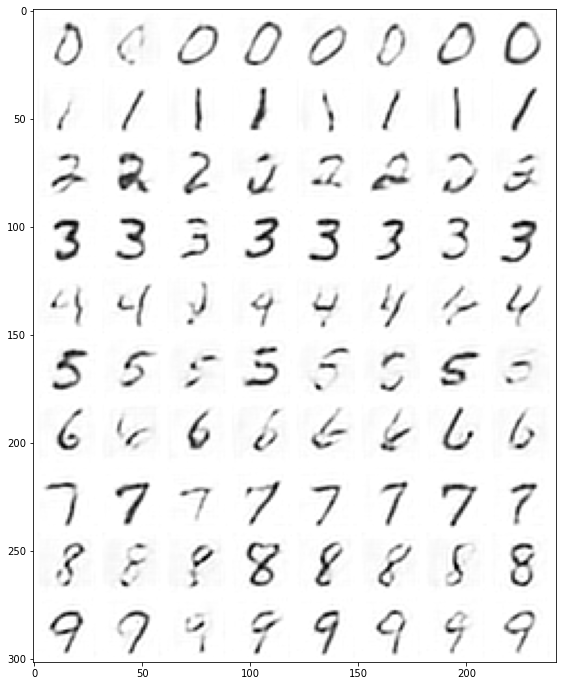

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(make_grid(xb.detach().cpu().clip(0, 1), nrow=8)[0]);

You can try fashion_mnist as the dataset without making any changes. This seems to work (suprisingly given the lack of fiddling with training and architecture). 